In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from tqdm import trange
from dataclasses import dataclass
import csv

In [2]:
from module import *

In [3]:
data_rows = {
    "e":  {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1},
    "r":  {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0},
    "c":  {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1},
    "cr": {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0},
    "l":  {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1},
    "lr": {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0},
    "lc": {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1},
    "f":  {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0},
    "off":{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
}
numbers = {
    0: "f lr lr lr f",
    1: "c c c c c",
    2: "f r f l f",
    3: "f r f r f",
    4: "lr lr f r r",
    5: "f l f r f",
    6: "f l f lr f",
    7: "f r r r r",
    8: "f lr f lr f",
    9: "f lr f r f",
}
empty = np.array([[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1]])

numbers_rows = {k: [data_rows[vv] for vv in v.split(" ")] for k, v in numbers.items()}


In [4]:
from ipywidgets import SelectMultiple, Select, Button, HBox, VBox, Output, IntRangeSlider, Checkbox, Accordion
def ui(data):
    def update_graph(b):
        fig, ax = plt.subplots(figsize=(8,8))
        s = np.concatenate(([x.value for x in select_nodes]))
        if np.isin('---', s):
            s = s[np.where(s != '---')].astype(int)
        for n in s:
            t = data.index.tolist()
            ax.step(t[xw.value[0]:xw.value[1]], data[n][xw.value[0]:xw.value[1]])
        ax.legend([int(n) for n in s])
        with graph:
            graph.clear_output()
            display(plt.show())


    graph = Output()
    layer_select = Select(
        options=net.nodes.layer.unique(),
        value=0,
        description='Слой'
    )

    type_chboxs = []
    for t in net.nodes.type.unique():
        type_chboxs.append(Checkbox(
            value=True,
            description=t,
            disabled=False
        ))
    select_nodes = []
    for t in type_chboxs:
        v = t.value
        if v:
            select_nodes.append(
                SelectMultiple(
                    options=np.insert(np.array(net.nodes.query(f"type=='{t.description}'").index.tolist(),dtype=object), 0, '---'),
                    description=t.description
                )
            )
            select_nodes[-1].rows = min(len(select_nodes[-1].options), 10)

    def on_layer_change(change):
        select_nodes = []
        for t in type_chboxs:
            v = t.value
            if v:
                select_nodes.append(
                    SelectMultiple(
                        options=np.insert(np.array(net.nodes.query(f"type=={t.description}").index.tolist(),dtype=object), 0, '---'),
                        description=t.description
                    )
                )
                select_nodes[-1].rows = min(len(select_nodes[-1].options), 10)

    layer_select.observe(on_layer_change, names='value')

    xw = IntRangeSlider(
        min=data.index.min(),
        max=data.index.max(),
        value=(data.index.min(), data.index.max()),
        description='Окно просмотра',
        disabled=False
    )
    select = Accordion(children=[VBox(type_chboxs), VBox(select_nodes)])
    select.selected_index=1
    select.set_title(0, 'Типы')
    select.set_title(1, 'Ноды')
    xw.observe(update_graph, names='value')
    [x.observe(update_graph, names='value') for x in select_nodes]
    draw = Button(description='Draw')
    draw.on_click(update_graph)
    return HBox((VBox((xw,select,draw)), graph))

In [5]:
def draw_network(net):
    import networkx as nx
    edges = []
    pos = {}
    n_in = {}
    for node, (_, priority, listen, cast, __) in net.nodes.iterrows():
        if listen is not None:
            try:
                iter(listen)
            except:
                listen = [listen]
            for l in listen:
                edges.append((l, node))
        if cast is not None:
            try:
                iter(cast)
            except:
                cast = [cast]
            for c in cast:
                edges.append((node, c))
        if priority not in n_in:
            n_in[priority] = 0
        pos[node] = (priority, n_in[priority])
        n_in[priority] += 0.5
    G = nx.DiGraph()
    G.add_edges_from(edges)
    plt.figure(figsize=(15,15))
    options = {
        "font_size": 12,
        "node_size": 300,
        "node_color": "white",
        "edgecolors": "blue",
        "linewidths": 2,
        "width": 2,
        "connectionstyle": 'arc3, rad = 0.3'
    }
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    nx.draw_networkx(G, pos, **options)
    plt.show()

In [6]:
params_rows = {
    "tau_leak": 1, 
    "tau_inhibitory": 1,
    "tau_refractory": 1,
    "tau_ltp": 1, 
    "thres": 750,
    "ainc": 30, 
    "adec": -15, 
    "wmax": 255, 
    "wmin": 1,
    "learning": False,
    "wta": True
}
weights_rows = np.array([
    [1, 1, 1, 255, 255, 255],
    [1, 1, 255, 255, 255, 1],
    [1, 255, 1, 255, 1, 255],
    [1, 255, 255, 255, 1, 1],
    [255, 1, 1, 1, 255, 255],
    [255, 1, 255, 1, 255, 1],
    [255, 255, 1, 1, 1, 255],
    [255, 255, 255, 1, 1, 1]
])
labels_rows = [
    "e",
    "r",
    "c",
    "cr",
    "l",
    "lr",
    "lc",
    "f"
]
params_digits = {
    "tau_leak": 50, 
    "tau_inhibitory": 30, 
    "tau_refractory": 300,
    "tau_ltp": 50 ,
    "thres": 500,
    "ainc": 20, 
    "adec": -15, 
    "wmax": 255, 
    "wmin": 1,
    "learning": True,
    "wta": True
}
weights_digits = np.array([
    [1, 1, 255, 1, 1, 1, 1, 1],
    [1, 255, 1, 1, 255, 1, 1, 255],
    [1, 1, 1, 1, 1,255, 1, 255]
])

In [7]:
nseq_d = []
nseq_l = []
test_data = [data_rows["off"].copy()]
test_labels = [-1]
a = None
for n in range(3):
    a = n
    test_data+=[x.copy() for x in numbers_rows[a]]
    test_labels+=[a for _ in numbers_rows[a]]
    test_labels.append(-1)
    test_data.append(data_rows["off"].copy())

for d, l in zip(test_data, test_labels):
    if l != -1:
        t = 10
    else:
        t = 50
        
    nseq_d.append(d.copy())
    nseq_l.append(l)
    for i in range(t-1):
        nseq_d.append(data_rows["off"].copy())
        nseq_l.append(l)

test_data = nseq_d
test_labels = nseq_l

In [8]:
data = []
ans = []
net = SpikeNetworkSim(inputs_l=6, dt=1)
net.new_layer(8, weights=weights_rows, **params_rows)
net.new_layer(3, weights=weights_digits, **params_digits) 
out = net.feed_raw(test_data)


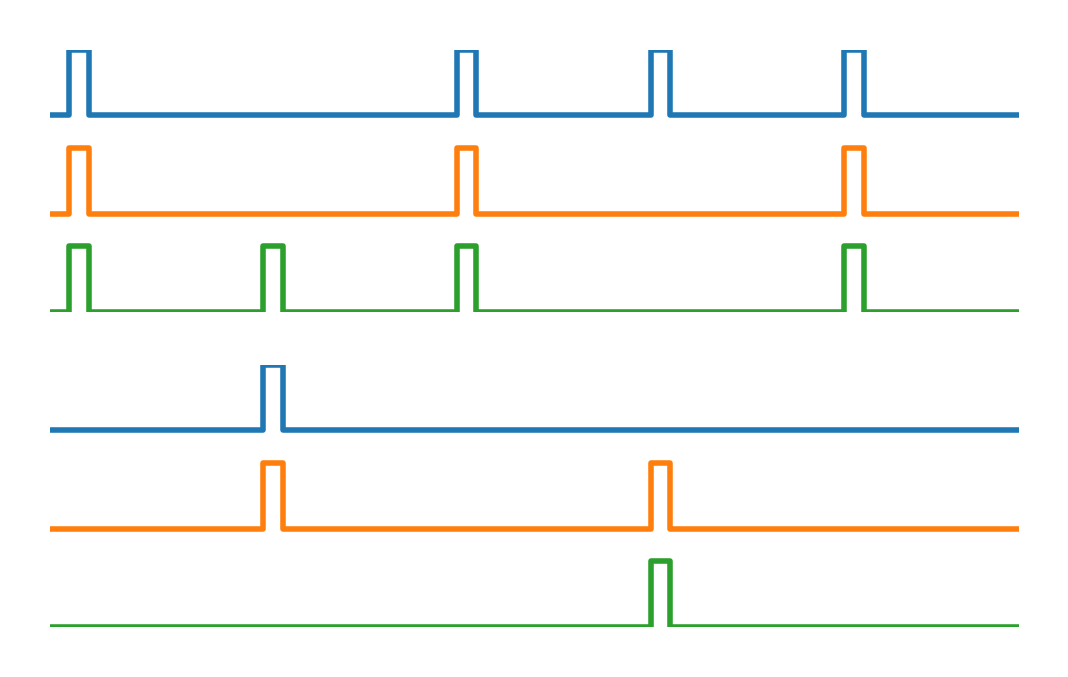

In [29]:
import matplotlib.font_manager as font_manager
from cycler import cycler
from matplotlib import gridspec

imin = 0
imax = 50
fig = plt.figure(figsize=(2.5, 1.5), dpi=500)
fig.tight_layout()
font = {"family":'Calibri',
        "weight":'normal',
        "style":'normal', 
        "size":10}

vth = 1.96
au_to_v = lambda x: vth/600*x

gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ind = np.array(out.index.to_list())+1-249

ax0 = plt.subplot(gs1[0])
ax0.step(ind, out[0].values+3, ind, out[1].values+1.5, ind, out[2].values, lw=.8)
ax0.set_xticks(())
ax0.set_xlim(imin, imax)

ax1 = plt.subplot(gs1[1])
ax1.step(ind, out[3].values+3, ind, out[4].values+1.5, ind, out[5].values, lw=.8)
ax1.set_xlim(imin, imax)
ax1.set_xticks(())
ax0.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
ax1.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
ax0.set_ylim(0,4)
ax0.set_yticks(())

ax1.spines.bottom.set_bounds(imin, imax)
ax1.spines.left.set_bounds(0, 4)
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax1.set_ylim(0,4)
ax1.set_yticks(())
plt.savefig('timediagrams.png', dpi=500)

(40.0, 345.0)

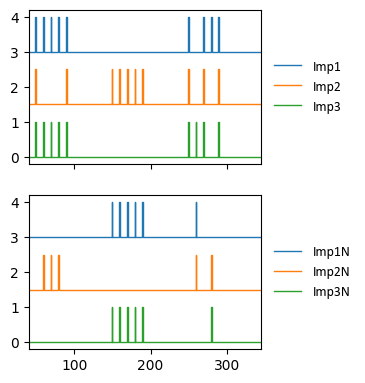

In [10]:
import matplotlib.font_manager as font_manager
from cycler import cycler
from matplotlib import gridspec

imin = 40
imax = 345
plt.figure(figsize=(3, 10))

font = {"family":'Calibri',
        "weight":'normal',
        "style":'normal', 
        "size":10}

vth = 1.96
au_to_v = lambda x: vth/600*x

gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, height_ratios=[1, 1], subplot_spec=gs[0])

ind = out.index.to_list()

ax0 = plt.subplot(gs1[0])
ax0.step(ind, out[0].values+3, ind, out[1].values+1.5, ind, out[2].values, lw=1)
ax0.legend(["Imp1", "Imp2", "Imp3"], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, prop=font)
ax0.xaxis.set_tick_params(labelbottom=False)
ax0.set_xlim(imin, imax)

ax1 = plt.subplot(gs1[1])
ax1.step(ind, out[3].values+3, ind, out[4].values+1.5, ind, out[5].values, lw=1)
ax1.legend(["Imp1N", "Imp2N", "Imp3N"], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False,  prop=font)
ax1.set_xlim(imin, imax)

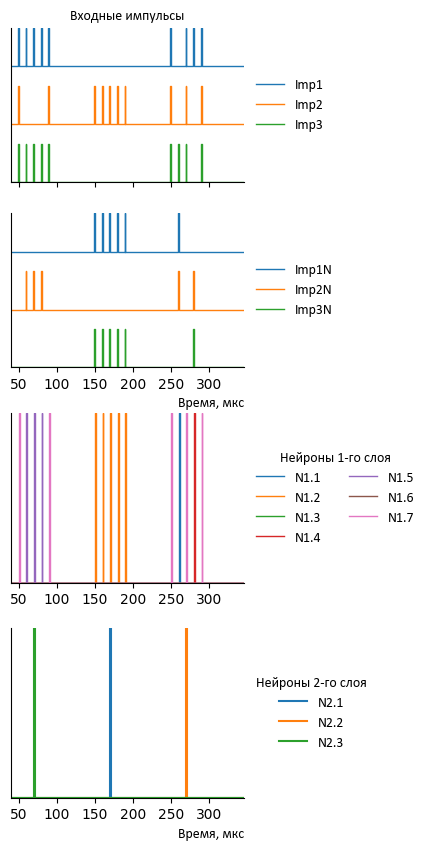

In [11]:
import matplotlib.font_manager as font_manager
from cycler import cycler
from matplotlib import gridspec

imin = 40
imax = 345
plt.figure(figsize=(3, 10))

font = {"family":'Calibri',
        "weight":'normal',
        "style":'normal', 
        "size":10}

vth = 1.96
au_to_v = lambda x: vth/600*x

gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, height_ratios=[1, 1], subplot_spec=gs[0])

ind = out.index.to_list()

ax0 = plt.subplot(gs1[0])
ax0.step(ind, out[0].values+3, ind, out[1].values+1.5, ind, out[2].values, lw=1)
ax0.legend(["Imp1", "Imp2", "Imp3"], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, prop=font)
ax0.xaxis.set_tick_params(labelbottom=False)
ax0.set_xlim(imin, imax)

ax1 = plt.subplot(gs1[1])
ax1.step(ind, out[3].values+3, ind, out[4].values+1.5, ind, out[5].values, lw=1)
ax1.legend(["Imp1N", "Imp2N", "Imp3N"], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False,  prop=font)
ax1.set_xlim(imin, imax)


ax3 = plt.subplot(gs[1])
for i in range(37, 44):
    ax3.step(ind, out[i], lw=1)
ax3.legend(["N1.1", "N1.2", "N1.3", "N1.4", "N1.5", "N1.6", "N1.7"], title="Нейроны 1-го слоя", loc='center left', ncols=2, bbox_to_anchor=(1, 0.5), frameon=False, prop=font, title_fontproperties=font)
ax3.set_xlim(imin, imax)

pres, posts = [], []

ax5 = plt.subplot(gs[2], sharex = ax3)
for i in range(53, 60, 3):
    posts.append(ax5.step(out[i].index.tolist(), out[i])[0])
    
ax5.legend(posts, ["N2.1", "N2.2", "N2.3"], title="Нейроны 2-го слоя", loc='center left', bbox_to_anchor=(1, 0.5), frameon=False,  prop=font, title_fontproperties=font)


ax0.spines.bottom.set_bounds(imin, imax)
ax0.spines.left.set_bounds(0, 4)
ax0.spines.right.set_visible(False)
ax0.spines.top.set_visible(False)
ax0.set_ylim(0,4)
ax0.set_xticks((50, 100, 150, 200,  250, 300))
ax0.set_yticks(())
ax0.set_title("Входные импульсы",  fontdict=font)
ax5.set_xlabel("Время, мкс", loc='right',  fontdict=font)

ax1.spines.bottom.set_bounds(imin, imax)
ax1.spines.left.set_bounds(0, 4)
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax1.set_ylim(0,4)
ax1.set_xticks((50, 100, 150, 200,  250, 300))
ax1.set_yticks(())
ax1.set_xlabel("Время, мкс", loc='right',  fontdict=font)


ax3.spines.bottom.set_bounds(imin, imax)
ax3.spines.left.set_bounds(0, 1)
ax3.spines.right.set_visible(False)
ax3.spines.top.set_visible(False)
ax3.set_ylim(0,1)
ax3.set_yticks(())
ax3.set_xticks((50, 100, 150, 200,  250, 300))
#ax3.set_xlabel("Время, мкс", loc='right',  fontdict=font)


ax5.spines.bottom.set_bounds(imin, imax)
ax5.spines.left.set_bounds(0, 1)
ax5.spines.right.set_visible(False)
ax5.spines.top.set_visible(False)
ax5.set_ylim(0,1)
ax5.set_yticks(())
ax5.set_xlabel("Время, мкс", loc='right',  fontdict=font)

plt.show()

C:\Users\Кормак\AppData\Local\Temp\ipykernel_19724\4278657340.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[1])


AttributeError: 'NoneType' object has no attribute 'dpi_scale_trans'

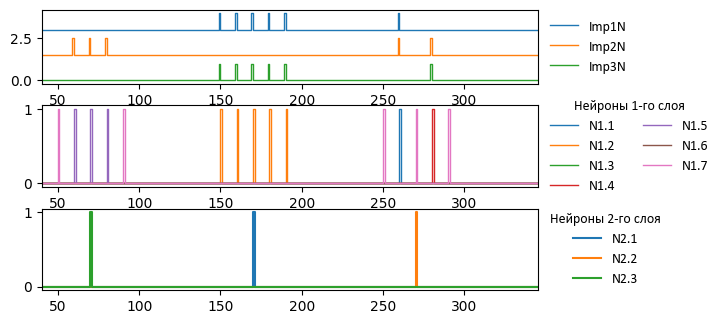

In [12]:
import matplotlib.font_manager as font_manager
from cycler import cycler
from matplotlib import gridspec


ax0 = plt.subplot()
ax0.step(ind, out[0].values+3, ind, out[1].values+1.5, ind, out[2].values, lw=1)
ax0.legend(["Imp1", "Imp2", "Imp3"], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, prop=font)
ax0.xaxis.set_tick_params(labelbottom=False)
ax0.set_xlim(imin, imax)

ax1 = plt.subplot(gs1[1])
ax1.step(ind, out[3].values+3, ind, out[4].values+1.5, ind, out[5].values, lw=1)
ax1.legend(["Imp1N", "Imp2N", "Imp3N"], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False,  prop=font)
ax1.set_xlim(imin, imax)


ax3 = plt.subplot(gs[1])
for i in range(37, 44):
    ax3.step(ind, out[i], lw=1)
ax3.legend(["N1.1", "N1.2", "N1.3", "N1.4", "N1.5", "N1.6", "N1.7"], title="Нейроны 1-го слоя", loc='center left', ncols=2, bbox_to_anchor=(1, 0.5), frameon=False, prop=font, title_fontproperties=font)
ax3.set_xlim(imin, imax)

pres, posts = [], []

ax5 = plt.subplot(gs[2], sharex = ax3)
for i in range(53, 60, 3):
    posts.append(ax5.step(out[i].index.tolist(), out[i])[0])
    
ax5.legend(posts, ["N2.1", "N2.2", "N2.3"], title="Нейроны 2-го слоя", loc='center left', bbox_to_anchor=(1, 0.5), frameon=False,  prop=font, title_fontproperties=font)


ax0.spines.bottom.set_bounds(imin, imax)
ax0.spines.left.set_bounds(0, 4)
ax0.spines.right.set_visible(False)
ax0.spines.top.set_visible(False)
ax0.set_ylim(0,4)
ax0.set_xticks((50, 100, 150, 200,  250, 300))
ax0.set_yticks(())
ax0.set_title("Входные импульсы",  fontdict=font)
ax5.set_xlabel("Время, мкс", loc='right',  fontdict=font)

ax1.spines.bottom.set_bounds(imin, imax)
ax1.spines.left.set_bounds(0, 4)
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax1.set_ylim(0,4)
ax1.set_xticks((50, 100, 150, 200,  250, 300))
ax1.set_yticks(())
ax1.set_xlabel("Время, мкс", loc='right',  fontdict=font)


ax3.spines.bottom.set_bounds(imin, imax)
ax3.spines.left.set_bounds(0, 1)
ax3.spines.right.set_visible(False)
ax3.spines.top.set_visible(False)
ax3.set_ylim(0,1)
ax3.set_yticks(())
ax3.set_xticks((50, 100, 150, 200,  250, 300))
#ax3.set_xlabel("Время, мкс", loc='right',  fontdict=font)


ax5.spines.bottom.set_bounds(imin, imax)
ax5.spines.left.set_bounds(0, 1)
ax5.spines.right.set_visible(False)
ax5.spines.top.set_visible(False)
ax5.set_ylim(0,1)
ax5.set_yticks(())
ax5.set_xlabel("Время, мкс", loc='right',  fontdict=font)

plt.show()

In [ ]:
imin = 240
imax = 300
plt.figure(figsize=(14, 9))

font = {"family":'Times New Roman',
        "weight":'normal',
        "style":'normal', 
        "size":10}

vth = 1.96
au_to_v = lambda x: vth/600*x

gs = gridspec.GridSpec(1, 2)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, height_ratios=[1, 1], subplot_spec=gs[0])
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, height_ratios=[1], subplot_spec=gs[1])

ind = np.arange(0, 60)

ax0 = plt.subplot(gs1[0])
ax0.step(ind, out[0].values[imin:imax]+3, ind, out[1].values[imin:imax]+1.5, ind, out[2].values[imin:imax], lw=1.5)
ax0.legend(["Imp1", "Imp2", "Imp3"], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, prop=font)
ax0.xaxis.set_tick_params(labelbottom=False)

ax1 = plt.subplot(gs1[1])
ax1.step(ind, out[3].values[imin:imax]+3, ind, out[4].values[imin:imax]+1.5, ind, out[5].values[imin:imax], lw=1.5)
ax1.legend(["Imp1N", "Imp2N", "Imp3N"], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False,  prop=font)

ax0.set_xlim(0, 60)
ax1.set_xlim(0, 60)

ax0.spines.left.set_bounds(0, 4)
ax0.spines.right.set_visible(False)
ax0.spines.top.set_visible(False)
ax0.set_ylim(0,4)
ax0.set_yticks(())
ax0.set_title("Входные импульсы",  fontdict=font)
ax1.spines.left.set_bounds(0, 4)
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax1.set_ylim(0,4)
ax1.set_yticks(())
ax1.set_xlabel("Время, мкс", loc='right',  fontdict=font)

ax2 = plt.subplot(gs2[0])
ax2.imshow(np.array([[0,0,0],[1,1,0],[0,0,0],[0,1,1],[0,0,0]]), cmap="gray")

In [ ]:
0/0
import matplotlib.font_manager as font_manager
from cycler import cycler

imin = 40
imax = 310
plt.figure(figsize=(7, 4.5))

font = {"family":'Times New Roman',
        "weight":'normal',
        "style":'normal', 
        "size":10}

plt.rc('axes', prop_cycle=cycler(color=["0.0", "0.4", "0.7"]))
vth = 1.96
au_to_v = lambda x: vth/600*x

gs = gridspec.GridSpec(1, 2)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, height_ratios=[1, 1], subplot_spec=gs[0])
gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios=[1, 2, 1], subplot_spec=gs[1])

ind = out.index.to_list()

ax0 = plt.subplot(gs1[0])
ax0.step(ind, out[0].values+3, ind, out[1].values+1.5, ind, out[2].values, lw=1)
ax0.legend(["Imp1", "Imp2", "Imp3"], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, prop=font)
ax0.xaxis.set_tick_params(labelbottom=False)
ax0.set_xlim(imin, imax)

ax1 = plt.subplot(gs1[1])
ax1.step(ind, out[3].values+3, ind, out[4].values+1.5, ind, out[5].values, lw=1)
ax1.legend(["Imp1N", "Imp2N", "Imp3N"], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False,  prop=font)
ax1.set_xlim(imin, imax)


default_cycler = (cycler(color=['0.0', '0.4', '0.7']) *
                  cycler(linestyle=['-', '--', ':'])
                 )


ax3 = plt.subplot(gs2[0])
ax3.set_prop_cycle(default_cycler)
for i in range(37, 44):
    ax3.step(ind, out[i], lw=1)
ax3.legend(["N1.1", "N1.2", "N1.3", "N1.4", "N1.5", "N1.6", "N1.7"], title="Нейроны 1-го слоя", loc='center left', ncols=2, bbox_to_anchor=(1, 0.5), frameon=False, prop=font, title_fontproperties=font)
ax3.xaxis.set_tick_params(labelbottom=False)
ax3.set_xlim(imin, imax)

pres, posts = [], []
ax4 = plt.subplot(gs2[1], sharex = ax3)
for i in range(52, 59, 3):
    pres.append(ax4.plot(au_to_v(out[i].values))[0])
ax4.xaxis.set_tick_params(labelbottom=False)
pres.append(ax4.step([imin, imax], [1.96, 1.96], 'k--', lw=2)[0])
    
ax5 = plt.subplot(gs2[2], sharex = ax3)
for i in range(53, 60, 3):
    posts.append(ax5.step(out[i].index.tolist(), out[i])[0])
    
ax5.legend(posts, ["N2.1", "N2.2", "N2.3"], title="Нейроны 2-го слоя", loc='center left', bbox_to_anchor=(1, 0.5), frameon=False,  prop=font, title_fontproperties=font)
ax4.legend(pres, ["N2.1", "N2.2", "N2.3", "Vth"], title="Выходы интеграторов\n с утечкой 2-го слоя", loc='center left', bbox_to_anchor=(1, 0.5), frameon=False,  prop=font, title_fontproperties=font)


ax0.spines.bottom.set_bounds(imin, imax)
ax0.spines.left.set_bounds(0, 4)
ax0.spines.right.set_visible(False)
ax0.spines.top.set_visible(False)
ax0.set_ylim(0,4)
ax0.set_xticks((50, 125, 200,  275))
ax0.set_yticks(())
ax0.set_title("Входные импульсы",  fontdict=font)
ax5.set_xlabel("Время, мкс", loc='right',  fontdict=font)

ax1.spines.bottom.set_bounds(imin, imax)
ax1.spines.left.set_bounds(0, 4)
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax1.set_ylim(0,4)
ax1.set_xticks((50, 125, 200,  275))
ax1.set_yticks(())
ax1.set_xlabel("Время, мкс", loc='right',  fontdict=font)


ax3.spines.bottom.set_bounds(imin, imax)
ax3.spines.left.set_bounds(0, 1)
ax3.spines.right.set_visible(False)
ax3.spines.top.set_visible(False)
ax3.set_ylim(0,1)
ax3.set_yticks(())
ax3.set_xticks((50, 125, 200,  275))

ax4.spines.bottom.set_bounds(imin, imax)
ax4.spines.right.set_visible(False)
ax4.set_ylim(0,2.2)
ax4.set_ylabel("U, В", loc='top', rotation=0, labelpad=-17,  fontdict=font)
ax4.spines.top.set_visible(False)

ax5.spines.bottom.set_bounds(imin, imax)
ax5.spines.left.set_bounds(0, 1)
ax5.spines.right.set_visible(False)
ax5.spines.top.set_visible(False)
ax5.set_ylim(0,1)
ax5.set_yticks(())
ax5.set_xlabel("Время, мкс", loc='right',  fontdict=font)

plt.subplots_adjust(wspace=1)
plt.show()

In [ ]:
net.nodes[50:]

In [ ]:
plt.step(np.arange(-10, 50), net.weights.loc[15].weights*out[net.nodes.iloc[15].listening[0]][240:300].values)

In [ ]:
gs = gridspec.GridSpec(1, 2)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, height_ratios=[1, 1], subplot_spec=gs[0])
gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, height_ratios=[1, 1], subplot_spec=gs[0])

ind = out.index.to_list()

ax0 = plt.subplot(gs1[0])

plt.step(np.arange(-10, 50), out[15][240:300])

In [ ]:
plt.step(np.arange(-10, 50), out[16][240:300])

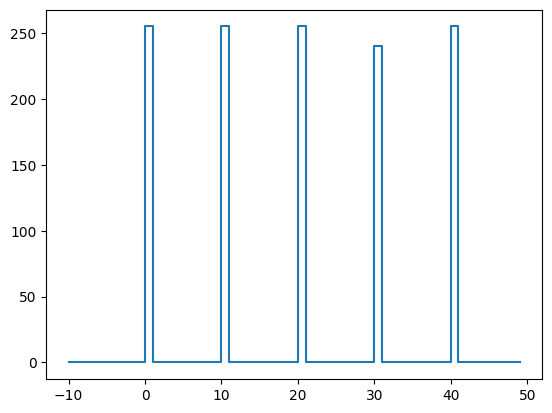

In [63]:
plt

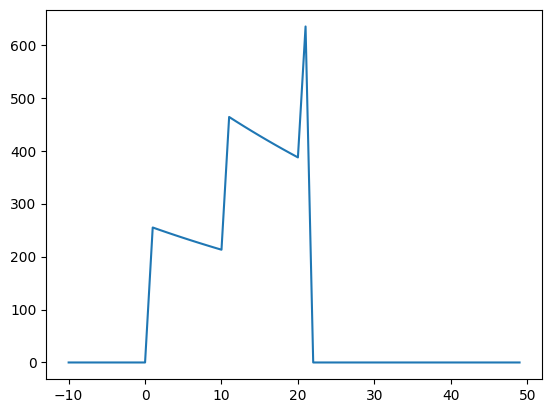

In [43]:
plt

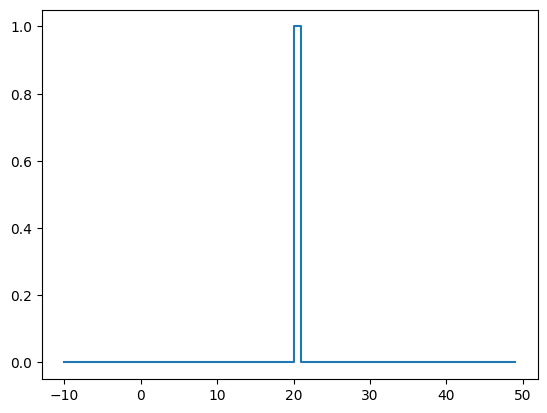

In [41]:
plt.step(np.arange(-10, 50), out[56][240:300])

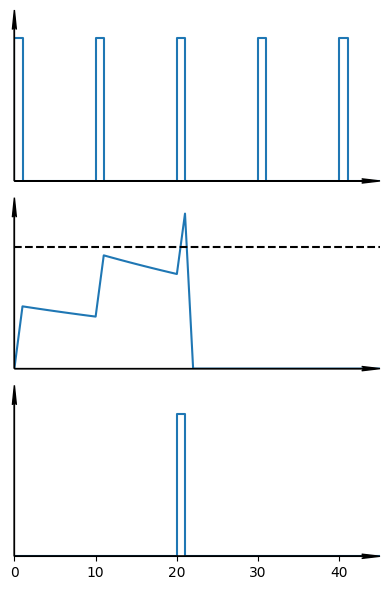

In [108]:
fig, ax = plt.subplots(3, 1, figsize=(4, 6))
ax[0].step(np.arange(-10, 50), np.sum(out[net.nodes.iloc[55].listening[0]][240:300].values, axis=1))
ax[1].plot(np.arange(-10, 50), out[55][240:300])
ax[2].step(np.arange(-10, 50), out[56][240:300])



def arrowed_spines(fig, ax):

    xmin, xmax = ax.get_xlim() 
    ymin, ymax = ax.get_ylim()

    # removing the default axis on all sides:
    for side in ['bottom','right','top','left']:
        ax.spines[side].set_visible(False)

    # get width and height of axes object to compute 
    # matching arrowhead length and width
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height

    # manual arrowhead width and length
    hw = 1./40.*(ymax-ymin) 
    hl = 1./20.*(xmax-xmin)
    lw = 1 # axis line width
    ohg = 0.3 # arrow overhang

    # compute matching arrowhead length and width
    yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
    yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

    # draw x and y axis
    ax.arrow(xmin, 0, xmax-xmin, 0., fc='k', ec='k', lw = lw, 
             head_width=hw, head_length=hl, overhang = ohg, 
             length_includes_head= True, clip_on = False, zorder=20) 

    ax.arrow(0, ymin, 0., ymax-ymin, fc='k', ec='k', lw = lw, 
             head_width=yhw, head_length=yhl, overhang = ohg, 
             length_includes_head= True, clip_on = False, zorder=20)

ax[0].set_ylim(0, 1.2)
ax[1].set_ylim(0, 700)
ax[2].set_ylim(0, 1.2)
for a in ax: 
    a.spines.right.set_visible(False)
    a.spines.top.set_visible(False)
    a.set_xlim(0,45)
    a.set_xticks(())
    a.set_yticks(())
    arrowed_spines(fig, a)
ax[2].set_xticks((0, 10, 20, 30, 40))

ax[1].plot((0,45), (500, 500), '--k')

fig.tight_layout()